# Introduction

The pourpose of this project is to demonstrate how different methods of feature selection can yield different accuracy scores. Also, for the purposes of this dataset, which feature selection method might work best?

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [92]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score,confusion_matrix, precision_score, recall_score, roc_auc_score


# Import and EDA on dataframe

In [93]:
df = pd.read_csv('default of credit card clients.csv')
print(df.columns)

# print(df.info())
df = df.drop(['ID'], axis=1)
print('Duplicates in DF: ', df.duplicated().sum())
df = df.drop_duplicates()
print('Null values in DF: ', df.isna().any().sum())
df.head()

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'dpnm'],
      dtype='object')
Duplicates in DF:  35
Null values in DF:  0


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,dpnm
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


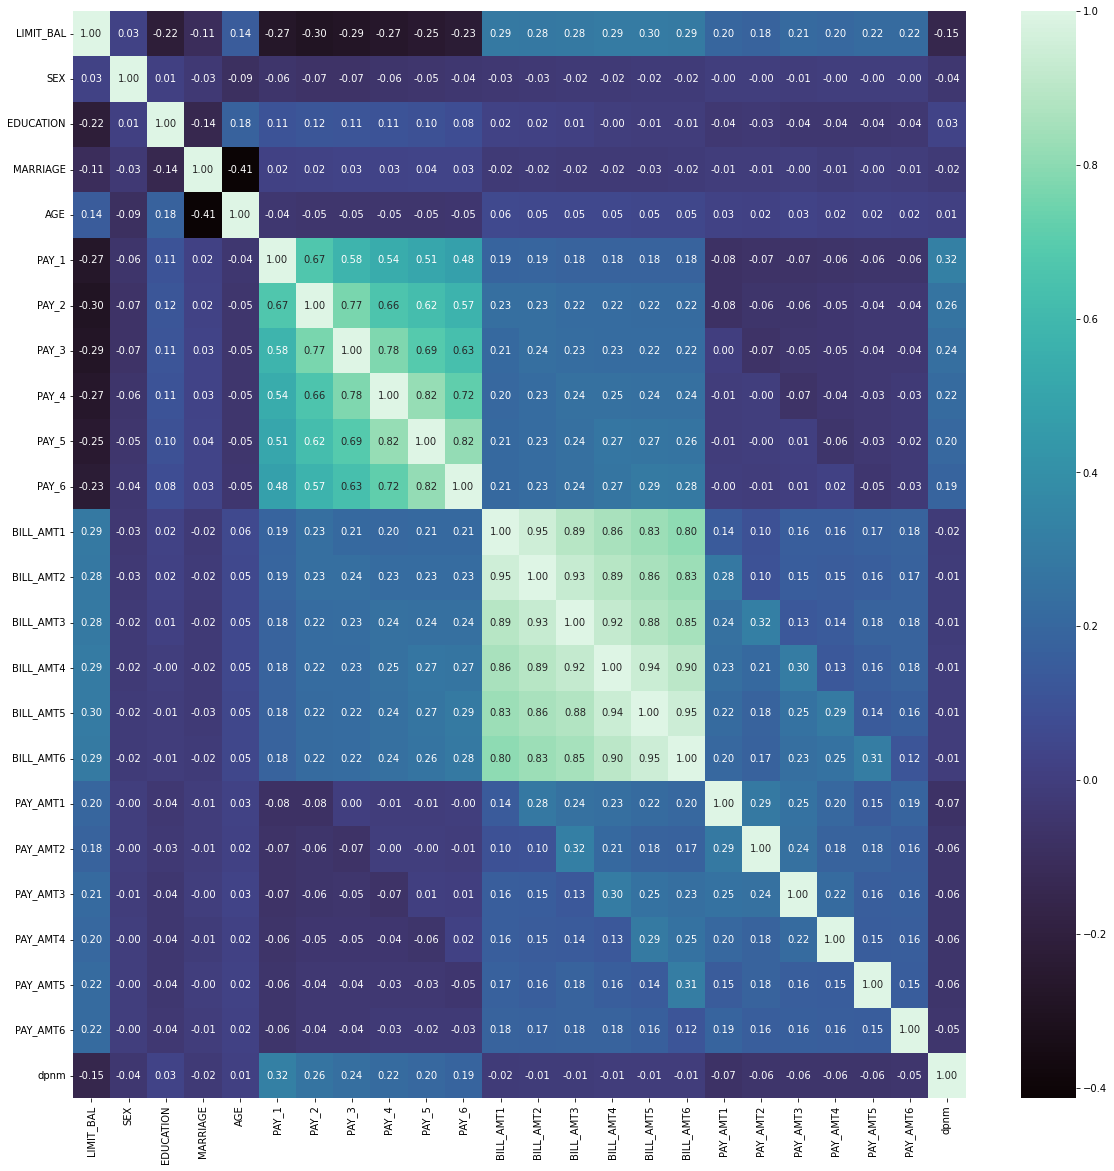

In [94]:
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(), annot=True, cmap='mako', fmt='.2f')
plt.show()

The Above heat map tells me that there is very little colinearity between any one parameter and the feature we want to predict. This means that any colinearity will be with a combination of features. 

Question to answer: How many features would work best?

In [95]:
X = df.drop('dpnm', axis=1)
y = df.iloc[:,-1]

lr = LogisticRegression(max_iter=1000)

# Create Sequential Featrue Selector Object

In [96]:
sfs = SFS(
    lr,
    k_features = len(X.columns),
    forward = True,
    floating = False,
    scoring = 'accuracy',
    cv=0
)


sfs.fit(X, y)
sfs.subsets_[6]


{'feature_idx': (1, 2, 3, 4, 5, 21),
 'cv_scores': array([0.81541799]),
 'avg_score': 0.8154179876522609,
 'feature_names': ('SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_AMT5')}

# Plot SFS scoring trend

C:\Users\joeyc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\joeyc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


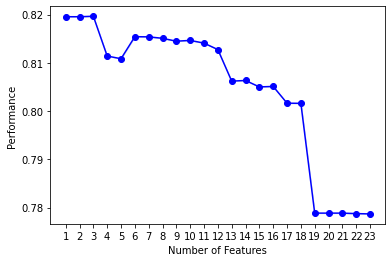

<Figure size 432x288 with 0 Axes>

In [97]:
plot_sfs(sfs.get_metric_dict())
plt.show()
plt.clf()

# Compare results with Sequential Forward Selection with floating

In [98]:
sfs_float = SFS(
    lr,
    k_features = 8,
    forward = True,
    floating = True,
    scoring = 'accuracy',
    cv=0
)


sfs_float.fit(X, y)
sfs_float.subsets_[6]

{'feature_idx': (1, 2, 3, 4, 5, 21),
 'cv_scores': array([0.81541799]),
 'avg_score': 0.8154179876522609,
 'feature_names': ('SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_AMT5')}

C:\Users\joeyc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\joeyc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


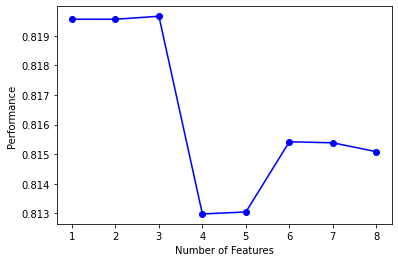

<Figure size 432x288 with 0 Axes>

In [99]:
plot_sfs(sfs_float.get_metric_dict())
plt.show()
plt.clf()

# Recursive Feature Selection

In [100]:
X = StandardScaler().fit_transform(X)

rfe = RFE(lr, n_features_to_select=6)

rfe.fit(X, y)
print('Recursive Feature Selector Score: %.4f' % rfe.score(X, y))

Recursive Feature Selector Score: 0.8102


# Wrapper feature selection

Use Cross-validation and Lasso and/or Ridge methods for feature selection

In [101]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV( Cs=np.logspace(-3,2, 100),
                                  penalty='l2',
                                  scoring='accuracy', cv=5,
                                  random_state=42,max_iter=10000)

model.fit(X, y)
print(model.C_, model.scores_[1].mean(axis=0).max())

[0.16681005] 0.8098114466878024


: 

Model score for Ridge method was 80.9%. Not the best score of the models tried so far.

# Conclusion

Model with the best score for this data set used Sequential Forward Selection with an accuracy score of 81.5%. 

Using this model will allow someone to predict whether or not a Credit Card holder will default on their next billing period with a 81.5% certainty.